This is the class for Data Preprocessing.
It will be used for signal plotting, hamming window creation and spectrogram creation. 
These spectrogram will be saved as numpy array as well as pictures to fed into machines.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import cv2

#This is the class to pre process any data file related to the project
class DataPreProcessing:
    #Global Variables
    global numberOfPsdValuesTobeTaken
    global windowLen
    global slidingStep
    
    numberOfPsdValuesTobeTaken = 512
    windowLen = 1024
    slidingStep = 512
    
    def __init__(self, fileName):
        #class variables
        self.dataset = pd.read_csv(fileName)
        self.X = self.dataset.iloc[:, :-1].values #All data set row with values without the classification column
        self.Y = self.dataset.iloc[:, -1].values #All data set classification values
        self.length_Of_Signal = len(self.X[1, :])
        self.number_Of_Signals = len(self.Y)
        
    def plot_Signal(self, signalNumber):
        y_plot = self.dataset.iloc[signalNumber, :-1]
        x_plot = np.arange(self.length_Of_Signal)
        plt.figure(figsize=(30,30)) 
        plt.plot(x_plot, y_plot)
        
    def hamming_Window_and_power_spectral_density(self, signalNumber, windowLen, slidingStep):
        hamming_window = np.hamming(windowLen)
        signal = self.X[signalNumber, : ]
        power_spectral_density_list = []
        for i in range(0, len(signal) - windowLen, slidingStep):
            windowed_signal = signal[i:i+windowLen] * hamming_window
            fft_output = np.fft.fft(windowed_signal)
            psd = np.square(np.abs(fft_output)) / windowLen
            power_spectral_density_list.append(psd)
        return power_spectral_density_list
    
    def save_Spectogram(self, spectrogramFilePath, numpyFilePath, optionalDrawingSignalNumber=None):
        for i in range(self.number_Of_Signals):
            psd_list = self.hamming_Window_and_power_spectral_density(i, windowLen=windowLen, slidingStep=slidingStep)
            full_Spectrogram = np.array(psd_list).T
            spectrogram = full_Spectrogram[:numberOfPsdValuesTobeTaken]
            max_value = np.max(spectrogram)
            scaled_spectrogram = spectrogram / max_value
            resized_spectrogram = cv2.resize(scaled_spectrogram, (256, 256))
            log_spectrogram = np.log(resized_spectrogram + 1e-10)
            normalized_spectrogram = (log_spectrogram - np.min(log_spectrogram)) / np.ptp(log_spectrogram)
            full_spectrogram_file_path = spectrogramFilePath + f'/spectrogram_{i}.png'
            plt.imsave(full_spectrogram_file_path, normalized_spectrogram, cmap='magma')
            full_numpy_file_path = numpyFilePath + f'/spectrogram_{i}.npy'
            np.save(full_numpy_file_path, normalized_spectrogram)
            
            #check if there is any drawing signal number and plot it
            if optionalDrawingSignalNumber != None:
                if optionalDrawingSignalNumber == i:
                    plt.imshow(normalized_spectrogram, cmap='magma')
                    plt.colorbar()
                    plt.xlabel('Time (window index)')
                    plt.ylabel('Frequency (Hz)')
                    plt.show()
                else:
                    continue
            else:
                continue

The followinf two snippets are used for calling the data preprocessing class and making spectrograms.

3749


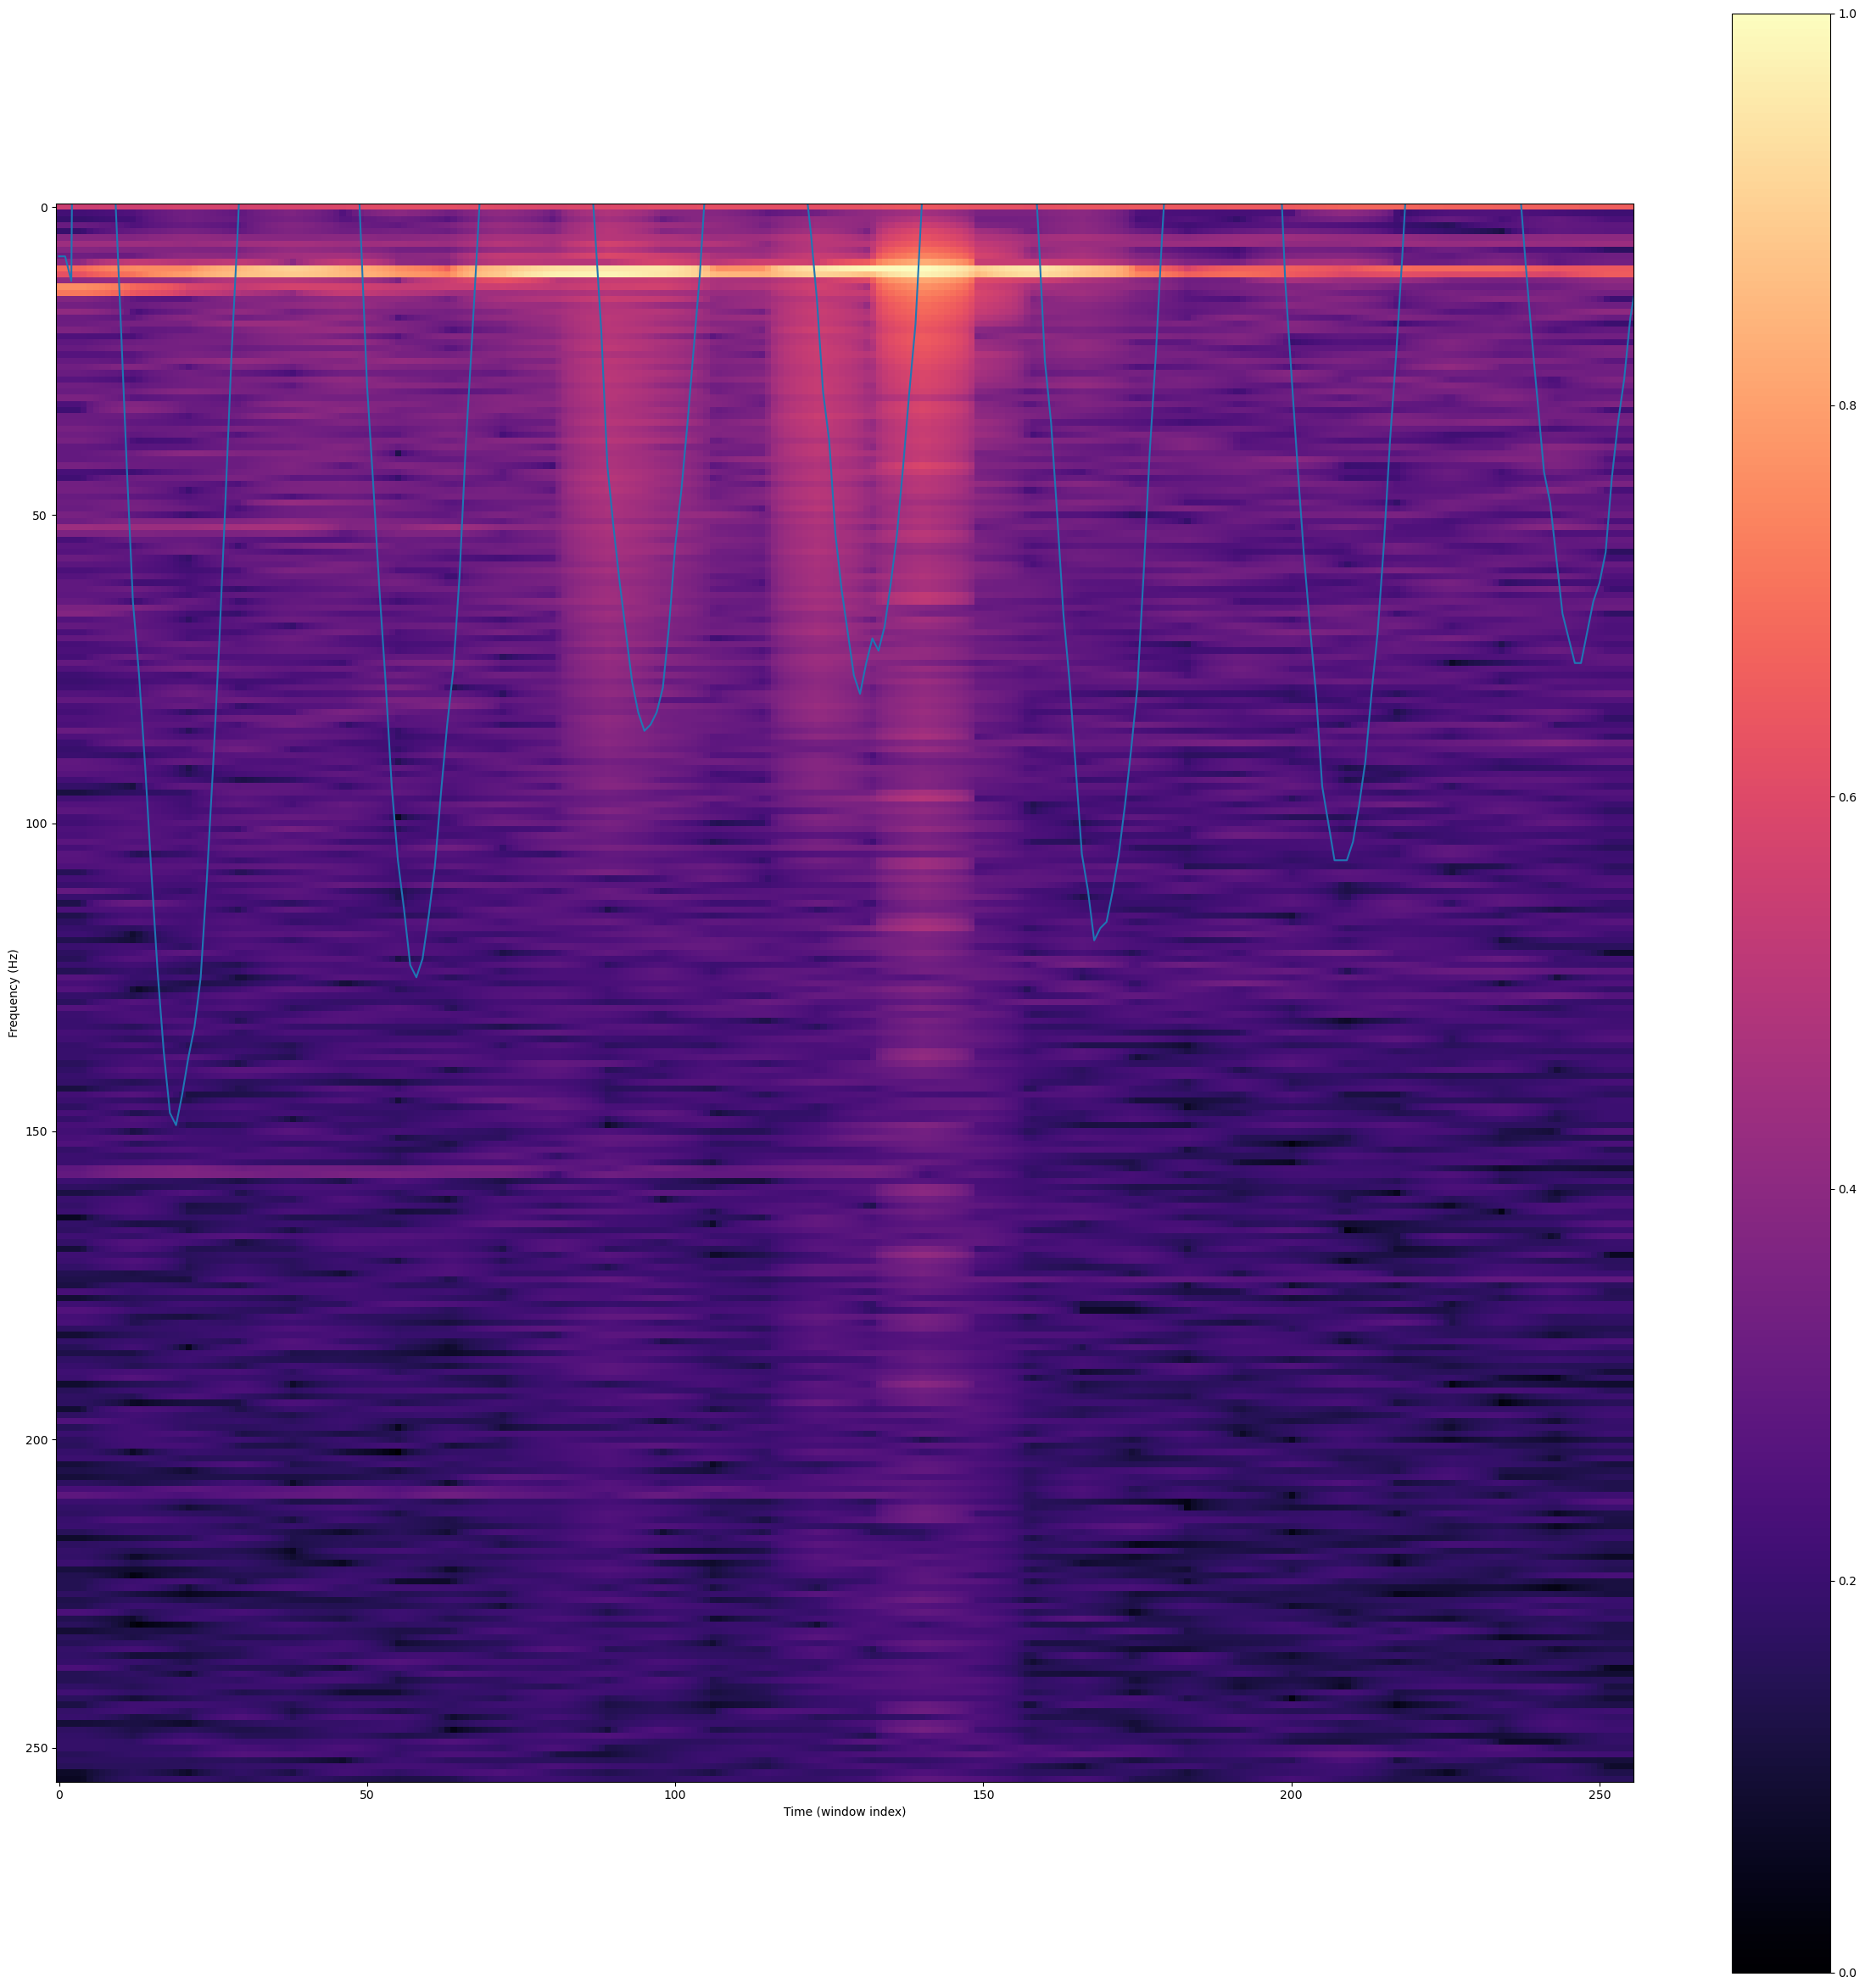

In [3]:
data = DataPreProcessing(fileName= "C:/Users/mashn/OneDrive/IT Course/Third semester/Machinne Learning/Coding Part/UpperSensorCombinedData.csv") 
data.plot_Signal(5)
print(data.number_Of_Signals)
#psd = data.hamming_Window(windowLen= 1024, slidingStep= 512)
data.save_Spectogram(spectrogramFilePath='F:/MLProject/Uppersensor/Spectrograms', numpyFilePath='F:/MLProject/Uppersensor/numpys', optionalDrawingSignalNumber=5)

5249


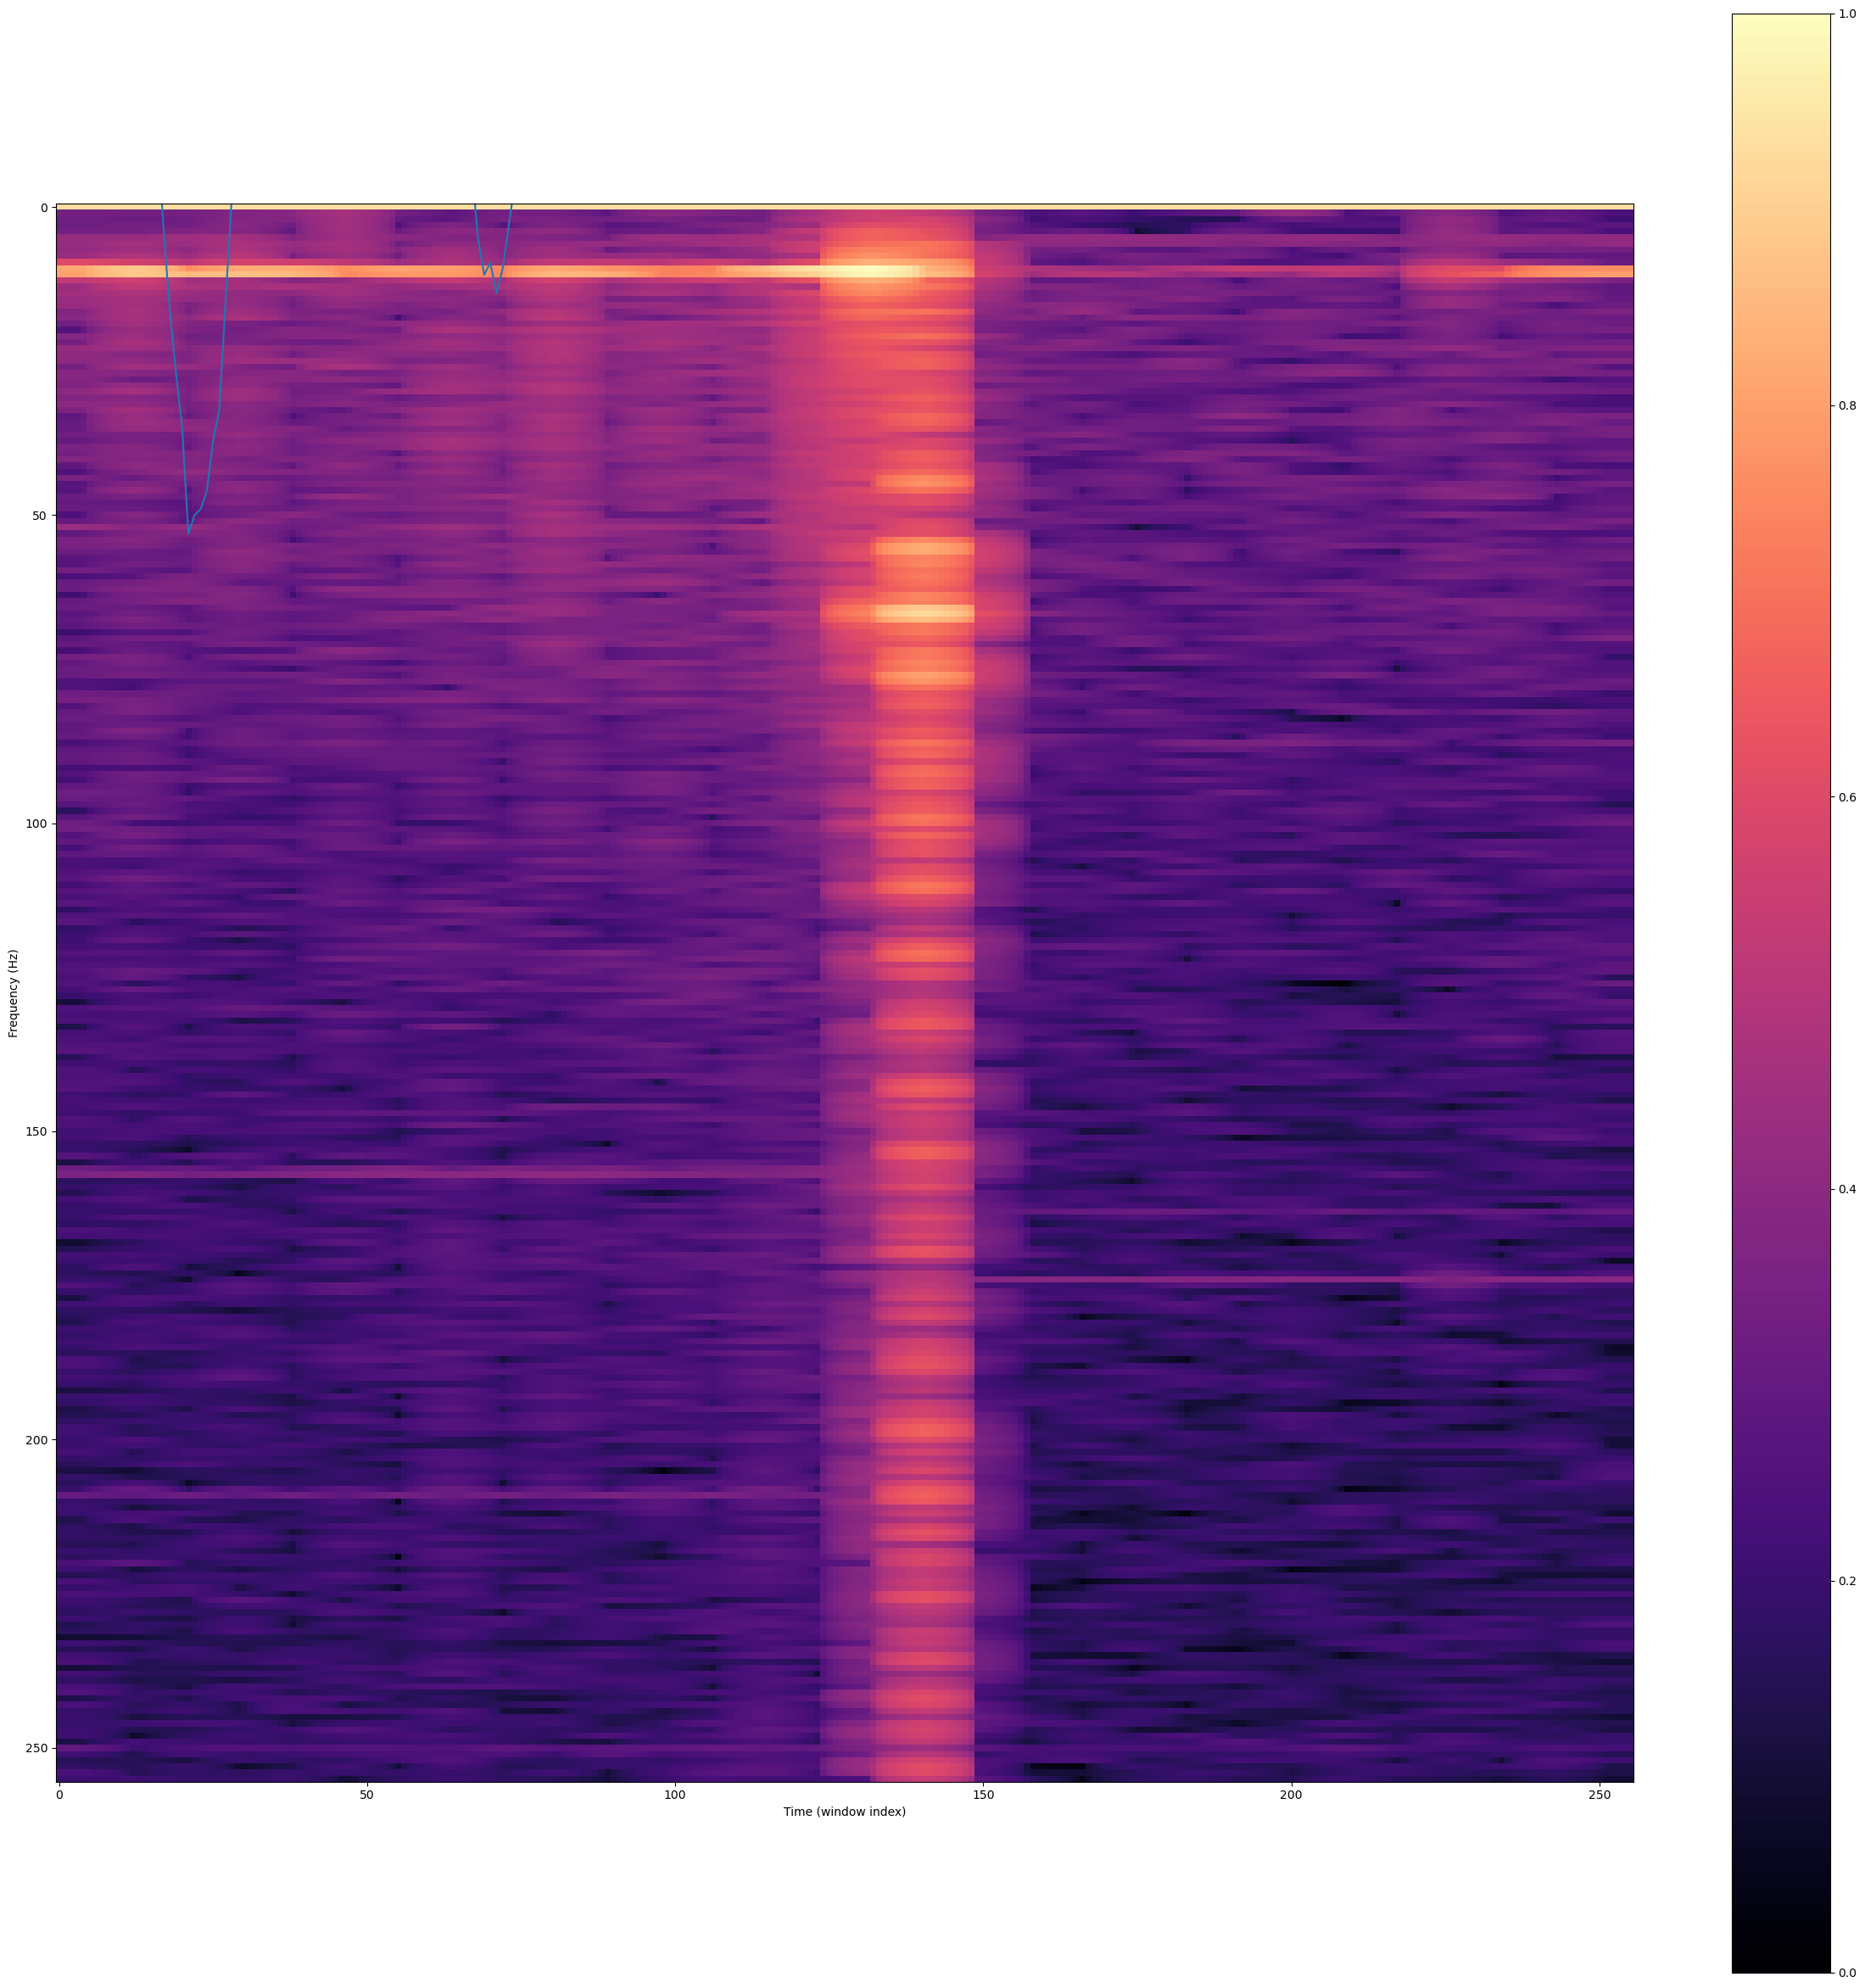

In [4]:
data = DataPreProcessing(fileName= "LowerSensorCombinedData.csv") 
data.plot_Signal(5)
print(data.number_Of_Signals)
#psd = data.hamming_Window(windowLen= 1024, slidingStep= 512)
data.save_Spectogram(spectrogramFilePath='F:/MLProject/Lowersensor/Spectrograms', numpyFilePath='F:/MLProject/Lowersensor/numpys', optionalDrawingSignalNumber=5)

Now In the following snippet class for CNN machine building is done

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

#this is the class for CNN machine building training and predicting
class CNNMachine:
    global model
    model = Sequential()
    def __init__(self, csvFileName, spectrogramFolderName):
        #class variables
        self.dataset = pd.read_csv(csvFileName)
        self.Y = self.dataset.iloc[:, -1].values #All data set classification values
        number_Of_Signals = len(self.Y)
        spectrograms_list = []
        for j in range(number_Of_Signals):
            exact_FileName = spectrogramFolderName + f'/spectrogram_{j}.npy'
            spectrogram = np.load(exact_FileName)
            spectrograms_list.append(spectrogram)
        self.spectrograms_array = np.array(spectrograms_list)
        self.encoded_Y = None
        self.train_spectrograms = None
        self.test_spectrograms = None
        self.train_labels = None
        self.test_labels = None
    
    def confusionMatrix(self, actual_labels, predicted_labels):
        classes = np.unique(actual_labels)
        cm = confusion_matrix(actual_labels, predicted_labels)
        # plot the confusion matrix as a heatmap
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes,
               ylabel='True label', xlabel='Predicted label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        
        # add text labels to each cell
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
        
        fig.tight_layout()
        plt.show()
    
    def encodeClassification(self):
        encoder = LabelEncoder()
        encoder.fit(self.Y)
        self.encoded_Y = encoder.transform(self.Y)
        label_encoding_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
        print(label_encoding_name_mapping)
        
    def trainTestSplitting(self, testSize=0.15, randomState=42):
        self.train_spectrograms, self.test_spectrograms, self.train_labels, self.test_labels = train_test_split(self.spectrograms_array, self.encoded_Y, test_size=testSize, random_state=randomState)
        #We need to resize the shapes
        self.train_spectrograms = self.train_spectrograms.reshape((self.train_spectrograms.shape[0], self.train_spectrograms.shape[1], self.train_spectrograms.shape[2], 1))
        self.test_spectrograms = self.test_spectrograms.reshape((self.test_spectrograms.shape[0], self.test_spectrograms.shape[1], self.test_spectrograms.shape[2], 1))
    
    def trainingMachine(self, inputShape=(256,256,1)):
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        #Training of the CNN
        history = model.fit(self.train_spectrograms, self.train_labels, batch_size=32, epochs=10, validation_split = 0.2)
        print("Training of Machine completed")
        #Testing of CNN
        test_loss, test_acc = model.evaluate(self.test_spectrograms, self.test_labels)
        print('Test accuracy:', test_acc)
        
    def predict(self, dataSpectrograms, actualLabels):
        y_pred = model.predict(dataSpectrograms)
        prediction_binary_array = np.where(y_pred >= 0.5, 1, 0)
        self.confusionMatrix(actualLabels, prediction_binary_array)
        
    def onlypredict(self, dataSpectrograms, actualLabels):
        y_pred = model.predict(dataSpectrograms)
        prediction_binary_array = np.where(y_pred >= 0.5, 1, 0)
        return prediction_binary_array
        

In [ ]:
uppersensorMachine = CNNMachine(csvFileName="C:/Users/mashn/OneDrive/IT Course/Third semester/Machinne Learning/Coding Part/UpperSensorCombinedData.csv", spectrogramFolderName="F:/MLProject/Uppersensor/numpys")
uppersensorMachine.encodeClassification()
uppersensorMachine.trainTestSplitting(testSize=0.15, randomState=42)
uppersensorMachine.trainingMachine(inputShape=(256,256,1))
uppersensorMachine.predict(uppersensorMachine.test_spectrograms, uppersensorMachine.test_labels)

{'nonperson': 0, 'person': 1}
Epoch 1/10
80/80 [==============================] - 334s 4s/step - loss: 0.4850 - accuracy: 0.7590 - val_loss: 0.1743 - val_accuracy: 0.9451
Epoch 2/10
80/80 [==============================] - 329s 4s/step - loss: 0.1717 - accuracy: 0.9368 - val_loss: 0.0931 - val_accuracy: 0.9749
Epoch 3/10
80/80 [==============================] - 330s 4s/step - loss: 0.1014 - accuracy: 0.9651 - val_loss: 0.0699 - val_accuracy: 0.9734
Epoch 4/10
80/80 [==============================] - 318s 4s/step - loss: 0.0926 - accuracy: 0.9706 - val_loss: 0.0758 - val_accuracy: 0.9765
Epoch 5/10
80/80 [==============================] - 327s 4s/step - loss: 0.0825 - accuracy: 0.9772 - val_loss: 0.0520 - val_accuracy: 0.9828
Epoch 6/10
80/80 [==============================] - 331s 4s/step - loss: 0.0647 - accuracy: 0.9796 - val_loss: 0.0427 - val_accuracy: 0.9875
Epoch 7/10
80/80 [==============================] - 381s 5s/step - loss: 0.0691 - accuracy: 0.9804 - val_loss: 0.0441 - val_

{'nonperson': 0, 'person': 1}
Epoch 1/10
112/112 [==============================] - 532s 5s/step - loss: 0.3745 - accuracy: 0.8268 - val_loss: 0.0356 - val_accuracy: 0.9854
Epoch 2/10
112/112 [==============================] - 503s 4s/step - loss: 0.0156 - accuracy: 0.9978 - val_loss: 0.0149 - val_accuracy: 0.9955
Epoch 3/10
112/112 [==============================] - 509s 5s/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 0.0033 - val_accuracy: 0.9989
Epoch 4/10
112/112 [==============================] - 469s 4s/step - loss: 0.0053 - accuracy: 0.9992 - val_loss: 9.2389e-05 - val_accuracy: 1.0000
Epoch 5/10
112/112 [==============================] - 538s 5s/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 1.2941e-04 - val_accuracy: 1.0000
Epoch 6/10
112/112 [==============================] - 583s 5s/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 7/10
112/112 [==============================] - 531s 5s/step - loss: 0.0045 - accuracy: 0.9994 - v

NameError: name 'classes' is not defined

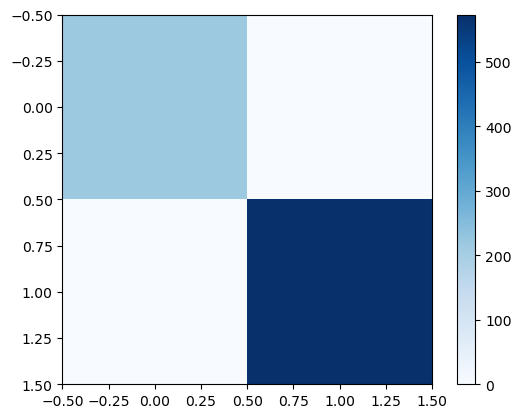

In [2]:
lowersensorMachine = CNNMachine(csvFileName="C:/Users/mashn/OneDrive/IT Course/Third semester/Machinne Learning/Coding Part/LowerSensorCombinedData.csv", spectrogramFolderName="F:/MLProject/Lowersensor/numpys")
lowersensorMachine.encodeClassification()
lowersensorMachine.trainTestSplitting(testSize=0.15, randomState=42)
lowersensorMachine.trainingMachine(inputShape=(256,256,1))
lowersensorMachine.predict(lowersensorMachine.test_spectrograms, lowersensorMachine.test_labels)

In [ ]:
def check(list1, list2):
    personSizeList = []
    size = ''
    for i in range(len(list1)):
        if ((list1[i] == 0) and (list2[i] == 1)):
            size = "small"
            personSizeList.append(size)
        elif ((list1[i] == 1) and (list2[i] == 1)):
            size = "adult"
            personSizeList.append(size)
        elif ((list1[i] == 0) and (list2[i] == 0)):
            size = "noperson"
            personSizeList.append(size)
            
def accuracy(list1, list2):
    wrongPredictionCount = 0
    smallWrongPredictionCount = 0
    adultWrongPredictionCount = 0
    nopersonWrongPredictionCount = 0
    for i in range(len(list1)):
        if (list1[i] != list2[i]):
            wrongPredictionCount += 1
            if (list1[i] == "small"):
                smallWrongPredictionCount += 1
            elif(list1[i] == "adult"):
                adultWrongPredictionCount += 1
            elif(list1[i] == "noperson"):
                nopersonWrongPredictionCount += 1
                
    print("wrongPredictionCount: {}, smallWrongPredictionCount: {}, adultWrongPredictionCount: {}, nopersonWrongPredictionCount: {}".format(wrongPredictionCount, smallWrongPredictionCount, adultWrongPredictionCount, nopersonWrongPredictionCount))
            
dataset1 = pd.read_csv("C:/Users/mashn/OneDrive/IT Course/Third semester/Machinne Learning/Coding Part/UpperSensorCombinedData.csv")
dataset2 = pd.read_csv("C:/Users/mashn/OneDrive/IT Course/Third semester/Machinne Learning/Coding Part/LowerSensorCombinedData.csv")
uppersensor_spectrograms_list = []
lowersensor_spectrograms_list = []
Y11 = dataset1.iloc[0:19, -1].values
Y12 = dataset1.iloc[1501:1519, -1].values
Y1 = np.concatenate((Y11, Y12))
Y21 = dataset2.iloc[0:29, -1].values
Y22 = dataset2.iloc[1501:1509, -1].values
Y2 = np.concatenate((Y21, Y22))
spectrogramFolderName1 = "F:/MLProject/Uppersensor/numpys"
spectrogramFolderName2 = "F:/MLProject/Lowersensor/numpys"
for j in range(0,19):
    exact_FileName = spectrogramFolderName1 + f'/spectrogram_{j}.npy'
    spectrogram = np.load(exact_FileName)
    uppersensor_spectrograms_list.append(spectrogram)
for j in range(1501 , 1519):
    exact_FileName = spectrogramFolderName1 + f'/spectrogram_{j}.npy'
    spectrogram = np.load(exact_FileName)
    uppersensor_spectrograms_list.append(spectrogram)

uppersensor_spectrograms_array = np.array(uppersensor_spectrograms_list)

for j in range(0,29):
    exact_FileName = spectrogramFolderName2 + f'/spectrogram_{j}.npy'
    spectrogram = np.load(exact_FileName)
    lowersensor_spectrograms_list.append(spectrogram)
for j in range(1501 , 1509):
    exact_FileName = spectrogramFolderName2 + f'/spectrogram_{j}.npy'
    spectrogram = np.load(exact_FileName)
    lowersensor_spectrograms_list.append(spectrogram)
    
lowersensor_spectrograms_array = np.array(lowersensor_spectrograms_list)
    
encoder = LabelEncoder()
encoder.fit(Y1)
encoded_Y1 = encoder.transform(Y1)
encoder.fit(Y2)
encoded_Y2 = encoder.transform(Y2)
label_encoding_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(label_encoding_name_mapping)

actualSizeList = check(encoded_Y1.tolist(), encoded_Y2.tolist())
uppersensorPrediction = uppersensorMachine.onlypredict(uppersensor_spectrograms_array, encoded_Y1)
lowersensorPrediction = lowersensorMachine.onlypredict(lowersensor_spectrograms_array, encoded_Y2)
predictionSizeList = check(uppersensorPrediction.tolist(), lowersensorPrediction.tolist())
accuracy(actualSizeList, predictionSizeList)

            
            